<a href="https://colab.research.google.com/github/Nastarii/PCB-defect-detection/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration

In [48]:
!pip install imageio

Upload the dataset from github

In [49]:
!wget --no-check-certificate \
    "https://github.com/tangsanli5201/DeepPCB/archive/refs/heads/master.zip" \
    -O "/tmp/DeepPCB.zip"

--2021-09-25 00:14:42--  https://github.com/tangsanli5201/DeepPCB/archive/refs/heads/master.zip
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/tangsanli5201/DeepPCB/zip/refs/heads/master [following]
--2021-09-25 00:14:43--  https://codeload.github.com/tangsanli5201/DeepPCB/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 52.68.31.213
Connecting to codeload.github.com (codeload.github.com)|52.68.31.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/DeepPCB.zip’

/tmp/DeepPCB.zip        [              <=>   ]  86.79M  22.2MB/s    in 3.9s    

2021-09-25 00:14:47 (22.1 MB/s) - ‘/tmp/DeepPCB.zip’ saved [91004517]



# Libraries

---



In [50]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2 as cv
import zipfile
import imageio
import imgaug
import torch
import PIL
import os

#Extract Dataset from zip

In [51]:
zip_format = zipfile.ZipFile('/tmp/DeepPCB.zip','r')
zip_format.extractall('/tmp')
zip_format.close()

# Split Train and Test set

In [52]:
directory = '/tmp/DeepPCB-master/PCBData/'

train_val_paths = pd.read_csv(directory + 'trainval.txt', delimiter = " ",header= None)
test_paths = pd.read_csv(directory + 'test.txt', delimiter = " ", header= None)

In [53]:
df = pd.concat([train_val_paths, test_paths],axis=0).sample(frac=1,random_state=42).drop(0,axis=1).rename(columns={1:'txt_files'})

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 116 to 126
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   txt_files  1500 non-null   object
dtypes: object(1)
memory usage: 23.4+ KB


In [55]:
train_val_files = df['txt_files'][:1000].values
test_files = df['txt_files'][:-500].values

# Read images

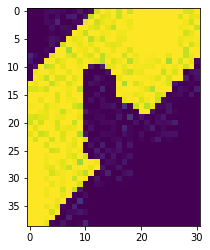

In [56]:
%matplotlib inline

image = PIL.Image.open(directory + 'group77000/77000/77000012_test.jpg')
crop_area = [365,128,396,167]
image = image.crop(crop_area)
plt.imshow(np.asarray(image))

# Prepare Image and Labels

In [57]:
os.makedirs('/tmp/PCBdefects')

FileExistsError: ignored

In [89]:
count = 0
class_labels = []
class_imgs = []

for txt in train_val_files:

    read_txt = pd.read_csv(directory + txt, delimiter= " ", header=None)
    img_path = txt.replace("_not","").replace(".txt","_test.jpg")

    for i in range (len(read_txt)):

        label = read_txt.iloc[i][4]
        class_labels.append(label)

        crop_area = read_txt.iloc[i][:4]
        image = PIL.Image.open(directory + img_path)
        image = image.crop(crop_area)
        image = image.resize((50,50),PIL.Image.ANTIALIAS,)
        image.save('/tmp/PCBdefects/defect' + str(count) + '_' + str(label) + '.jpg')
        class_imgs.append(np.asarray(image,dtype='float32'))
        count = count + 1

In [90]:
labels = pd.DataFrame(class_labels,columns=['Label'],dtype='int8')

In [91]:
labels = pd.get_dummies(labels,columns=['Label'])

In [92]:
labels = labels.rename(columns={'Label_1':'open','Label_2':'short',
                       'Label_3':'mousebite','Label_4':'spur',
                       'Label_5':'copper','Label_6':'pin-hole'})

In [93]:
labels.head()

,open,short,mousebite,spur,copper,pin-hole
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,0,0,0,1
4,0,0,0,0,1,0


In [94]:
categories = {0: {'id':1,'name':'open'},
              1: {'id':2,'name':'short'},
              2: {'id':3,'name':'mousebite'},
              3: {'id':4,'name':'spur'},
              4: {'id':5,'name':'copper'},
              5: {'id':6,'name':'pin-hole'}}

# Model

In [95]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import pathlib

In [96]:
trainX, testX, trainY, testY = train_test_split(class_imgs,
	labels, test_size=0.2, random_state=42)

aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

In [97]:
model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu',input_shape=(50, 50, 1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(6)
])

In [98]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [99]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 50, 50, 16)        160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)             